----
----
# <center><b> Assignment 3 - ML for Time Series </b></center>
# <center><b> MVA - 2023/2024 </b></center>
# Matteo Marengo | matteo.marengo@ens-paris-saclay.fr
# Hugo Robert | hugo.robert@ens-paris-saclay.fr


----
----
# <b>Setup</b>

**Imports**

In [1]:
import datetime as dt
from math import log
import IPython

import matplotlib.pyplot as plt
import contextily as cx
import numpy as np
import ruptures as rpt
from scipy.signal import spectrogram
from loadmydata.load_molene_meteo import load_molene_meteo_dataset
from math import asin, cos, radians, sin, sqrt
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from pygsp import graphs
import geopandas
import pandas as pd

rng = np.random.default_rng()

----
----
# <center><b> Dual-tone multi-frequency signaling (DTMF)</center></b>

----
----
# <b>Question 1</b>

The following cell loads the training data set `X_train` and `y_train`.
`X_train` is a list of 100 signals; `y_train` is a list of 100 symbol sequences. 

The signals have a varying number of symbols with a varying duration. 
There is a brief silence between each symbol.
The sampling frequency is $22.05 $ kHz.

## Vizualize data

In [2]:
FS = 22050  # sampling frequency (Hz)

X_train = np.load("X_train.npy", allow_pickle=True).tolist()
y_train = np.load("y_train.npy", allow_pickle=True).tolist()
X_test = np.load("X_test.npy", allow_pickle=True).tolist()
y_test = np.load("y_test.npy", allow_pickle=True).tolist()

In [3]:
signal, symbols = X_train[1], y_train[1]
print(" ".join(symbols))
IPython.display.Audio(signal, rate=FS)

8 7 C B 5 A 3


## Extraction of symbols from signals

In [4]:
def split_signal(signal, nb_symbol):
    """split signal according to a time-frequency analysis"""
    frequencies, times, Sxx = spectrogram(signal, FS)
    energy_signal = np.sum(Sxx, axis=0)
    change_points = rpt.Dynp(model="l2", jump=1).fit(energy_signal).predict(n_bkps=2*nb_symbol)
    change_points = [int(times[change_point-1]*FS) for change_point in change_points]
    return [signal[change_points[2*i]:change_points[2*i+1]] for i in range(len(change_points)//2)]

def find_frequencies(signal):
    """find f1 and f2 from a signal"""
    fft_result = np.fft.fft(signal)
    N = len(signal)
    positive_frequency_bins = np.fft.fftfreq(N, 1 / FS)[:N // 2]
    magnitude = np.abs(fft_result)[:N // 2]
    f1, f2 = sorted([positive_frequency_bins[np.argsort(magnitude)[-1]], positive_frequency_bins[np.argsort(magnitude)[-2]]])
    return f1, f2

def classify(f1, f2):
    """find the symbol from f1 and f2"""
    f1_classes = [697, 770, 852, 941]
    f2_classes = [1209, 1336, 1477, 1633]
    f1 = min(f1_classes, key=lambda x:abs(x-f1))
    f2 = min(f2_classes, key=lambda x:abs(x-f2))
    
    # map to symbol
    symbol_map = {
        (697, 1209): "1",
        (697, 1336): "2",
        (697, 1477): "3",
        (697, 1633): "A",
        (770, 1209): "4",
        (770, 1336): "5",
        (770, 1477): "6",
        (770, 1633): "B",
        (852, 1209): "7",
        (852, 1336): "8",
        (852, 1477): "9",
        (852, 1633): "C",
        (941, 1209): "*",
        (941, 1336): "0",
        (941, 1477): "#",
        (941, 1633): "D"
    }
    return symbol_map[(f1, f2)]

def infer_symbols(signal, nb_symbols):
    """find the symbols from a signal"""
    signals = split_signal(signal, nb_symbols)
    return [classify(*find_frequencies(s)) for s in signals]

In [5]:
#test our model on a training sample
pred = infer_symbols(signal, len(symbols))
print(f"predicted:\t{' '.join(pred)}\nTrue:\t\t{' '.join(symbols)}")

predicted:	C 7 C B 5 1 D
True:		8 7 C B 5 A 3


----
----
# <b>Question 2</b>

## Test of the model

In [6]:
accuracy = []
for X, y in zip(X_test, y_test):
    pred = infer_symbols(X, len(y))
    print(f"Predicted: {pred}, True: {y}")
    accuracy.append(np.sum([pred[i] == y[i] for i in range(len(pred))])/len(pred))
print(f"Accuracy: {np.mean(accuracy)}")

Predicted: ['7', '2', '3', 'C', '9', '9'], True: ['7', '2', '1', 'C', '9', '9']
Predicted: ['1', '#', '2', '#'], True: ['1', '#', '2', '#']
Accuracy: 0.9166666666666667


----
----
# <center><b> Wavelet transform for graph signals </center></b>

----
----
# <b>Question 3</b>

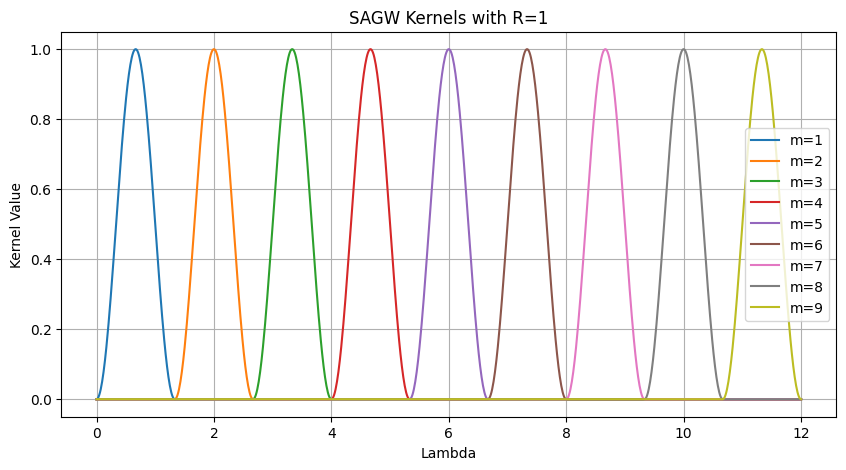

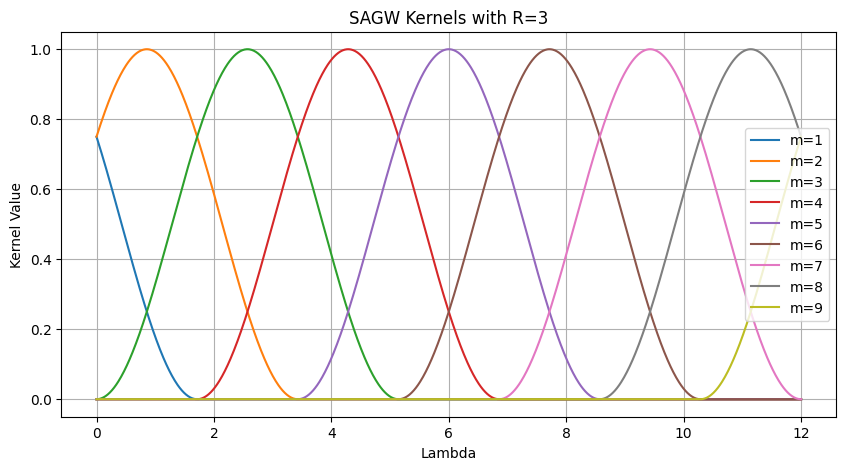

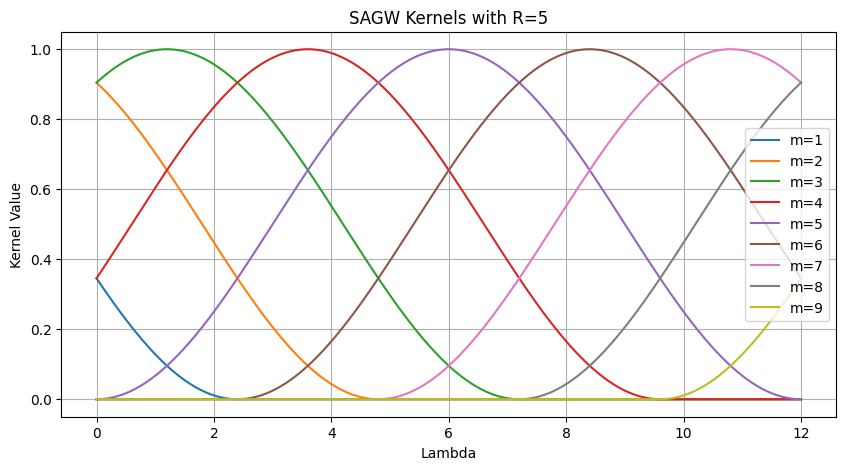

In [15]:
M = 9
lambda_n = 12
R_values = [1, 3, 5]

def sagw_kernel(lambda_, lambda_n, m, M, R):
    """Function to calculate the SAGW kernel"""
    assert 0<=lambda_<=lambda_n
    a = lambda_n / (M + 1 - R)
    g_U = lambda x: 0.5 * (1 + np.cos(2 * np.pi * (x / (a * R) + 0.5))) if -R * a <= x < 0 else 0
    return g_U(lambda_ - a * m)

lambdas = np.linspace(0, lambda_n, 1000)
for R in R_values:
    plt.figure(figsize=(10, 5))
    for m in range(1, M + 1):
        g_m = np.array([sagw_kernel(l, lambda_n, m, M, R) for l in lambdas])
        plt.plot(lambdas, g_m, label=f'm={m}')

    plt.title(f'SAGW Kernels with R={R}')
    plt.xlabel('Lambda')
    plt.ylabel('Kernel Value')
    plt.legend()
    plt.grid(True)
    plt.show()


----
----
# <b>Question 4</b>

## import data

In [16]:
data_df, stations_df, description = load_molene_meteo_dataset()
print(description)

The French national meteorological service made publicly available [1] a data set of hourly observations from a number of weather ground stations. Those stations are located in Brittany, France, and the data were collected during the month of January 2014. The stations recorded several meteorological variables, such as temperature, humidity, wind speed and direction, etc. Missing data (denoted by 'mq' in the original data) are replaced by NaNs.

In addition, the exact positions of the ground stations are provided.

Here is an excerpt of the README file that comes with the data.

    Descriptif  Mnémonique  type    unité
    Paramètres standard
    Indicatif INSEE station numer_sta   car
    Indicatif OMM station   id_omm  int
    Date    date    car
    Point de rosée  td  réel    K
    Température t    réel   K
    Température maximale de l'air   tx  réel    K
    Température minimale de l'air   tn  réel    K
    Humidité    u   int %
    Humidité maximale   ux  int %
    Humidité min

In [17]:
stations_df.head()

,Numéro,Nom,Latitude,Longitude,X (Lambert II étendu),Y (Lambert II étendu),Altitude
0,22016001,ILE-DE-BREHAT,48.855167,-3.004500,208083,2441852,25
1,22092001,KERPERT,48.404000,-3.147667,194096,2392507,281
2,22113006,LANNAERO,48.755333,-3.468667,173267,2433190,85
3,22135001,LOUARGAT,48.551667,-3.376833,178359,2410097,148
4,22147006,MERDRIGNAC,48.182667,-2.410833,247067,2364385,131


In [18]:
data_df["temp"] = data_df.t - 273.15  # temperature in Celsius
data_df = data_df.reset_index().drop("index", axis="columns")
data_df.head()

,numer_sta,date,date_insert,td,t,tx,tn,u,ux,un,...,vv,etat_sol,sss,n,insolh,ray_glo01,pres,pmer,station_name,temp
0,29168001,2014-01-01 00:00:00,2014-01-01 00:03:54,280.35,283.65,283.75,283.55,80.0,83.0,78.0,...,30000.0,1.0,NaN,1.0,NaN,NaN,99520.0,100490.0,PTE DU RAZ,10.5
1,29168001,2014-01-01 01:00:00,2014-01-01 01:03:59,279.45,282.95,283.85,282.95,79.0,82.0,78.0,...,NaN,NaN,NaN,NaN,NaN,NaN,99410.0,100380.0,PTE DU RAZ,9.8
2,29168001,2014-01-01 02:00:00,2014-01-01 02:04:05,280.85,283.75,283.75,282.55,82.0,84.0,80.0,...,NaN,NaN,NaN,NaN,NaN,NaN,99350.0,100320.0,PTE DU RAZ,10.6
3,29168001,2014-01-01 03:00:00,2014-01-01 03:03:09,280.95,283.75,283.85,283.65,83.0,84.0,80.0,...,30000.0,1.0,NaN,7.0,NaN,NaN,99230.0,100200.0,PTE DU RAZ,10.6
4,29168001,2014-01-01 04:00:00,2014-01-01 04:03:14,281.15,283.55,284.05,283.55,85.0,86.0,80.0,...,NaN,NaN,NaN,NaN,NaN,NaN,99110.0,100080.0,PTE DU RAZ,10.4


In [19]:
temperature_df = data_df.pivot(index="date", values="temp", columns="station_name")
temperature_df.head()

station_name,ARZAL,AURAY,BATZ,BEG_MEIL,BELLE ILE-LE TALUT,BIGNAN,BREST-GUIPAVAS,BRIGNOGAN,CAMARET,DINARD,...,SIBIRIL S A,SIZUN,SPEZET,ST BRIEUC,ST NAZAIRE-MONTOIR,ST-SEGAL S A,THEIX,TREGUNC,VANNES-MEUCON,VANNES-SENE
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,9.7,10.3,NaN,NaN,11.3,7.1,9.7,NaN,NaN,6.8,...,7.4,8.5,8.3,7.5,9.0,9.0,9.3,10.8,8.5,9.7
2014-01-01 01:00:00,9.8,10.4,NaN,NaN,10.3,7.6,9.6,9.2,NaN,6.5,...,8.2,8.3,8.6,7.0,9.1,9.5,9.1,10.9,8.7,9.9
2014-01-01 02:00:00,9.7,10.0,NaN,NaN,11.2,7.7,9.1,9.4,NaN,6.5,...,8.5,8.5,8.6,7.5,9.5,9.4,9.4,10.6,8.8,9.6
2014-01-01 03:00:00,9.4,10.4,NaN,NaN,11.4,7.9,9.7,10.1,NaN,7.1,...,8.5,8.7,8.9,7.2,9.0,9.9,8.9,10.8,8.6,9.8
2014-01-01 04:00:00,9.8,10.8,NaN,NaN,11.4,8.8,9.8,10.2,NaN,7.6,...,9.1,9.1,9.4,7.6,9.5,10.0,9.6,11.0,9.2,10.2


In [20]:
CRS = "EPSG:4326"

stations_gdf = geopandas.GeoDataFrame(
    stations_df,
    geometry=geopandas.points_from_xy(stations_df.Longitude, stations_df.Latitude),
).set_crs(CRS)

stations_gdf.head()

,Numéro,Nom,Latitude,Longitude,X (Lambert II étendu),Y (Lambert II étendu),Altitude,geometry
0,22016001,ILE-DE-BREHAT,48.855167,-3.004500,208083,2441852,25,POINT (-3.00450 48.85517)
1,22092001,KERPERT,48.404000,-3.147667,194096,2392507,281,POINT (-3.14767 48.40400)
2,22113006,LANNAERO,48.755333,-3.468667,173267,2433190,85,POINT (-3.46867 48.75533)
3,22135001,LOUARGAT,48.551667,-3.376833,178359,2410097,148,POINT (-3.37683 48.55167)
4,22147006,MERDRIGNAC,48.182667,-2.410833,247067,2364385,131,POINT (-2.41083 48.18267)


----
## <b>4.1: Remove all stations with missing values in the temperature</b>

In [21]:
stations_without_temp = pd.DataFrame(temperature_df.isna().sum(axis=0), columns=['Number of missing values'])
stations_without_temp = stations_without_temp[stations_without_temp['Number of missing values']!=0].index
print(f"Stations without temperature: {', '.join(stations_without_temp)}")

Stations without temperature: ARZAL, BATZ, BEG_MEIL, BREST-GUIPAVAS, BRIGNOGAN, CAMARET, LANDIVISIAU, LANNAERO, LANVEOC, OUESSANT-STIFF, PLOUAY-SA, PLOUDALMEZEAU, PLOUGONVELIN, QUIMPER, RIEC SUR BELON, SIZUN, ST NAZAIRE-MONTOIR, VANNES-MEUCON


In [22]:
# remove all stations with missing values in the temperature
data_df = data_df[~data_df["station_name"].isin(stations_without_temp)]
stations_df = stations_df[~stations_df["Nom"].isin(stations_without_temp)]
stations_gdf = stations_gdf[~stations_gdf["Nom"].isin(stations_without_temp)]
temperature_df = temperature_df.drop(stations_without_temp, axis="columns")

----
## <b>4.2: Create graph and find best threshold

In [7]:
def get_geodesic_distance(point_1, point_2) -> float:
    """
    Calculate the great circle distance (in km) between two points
    on the earth (specified in decimal degrees)

    https://stackoverflow.com/a/4913653
    """

    lon1, lat1 = point_1
    lon2, lat2 = point_2

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def get_exponential_similarity(condensed_distance_matrix, bandwidth, threshold):
    exp_similarity = np.exp(-(condensed_distance_matrix**2) / bandwidth / bandwidth)
    res_arr = np.where(exp_similarity > threshold, exp_similarity, 0.0)
    return res_arr

green when the graph is connected, red when not


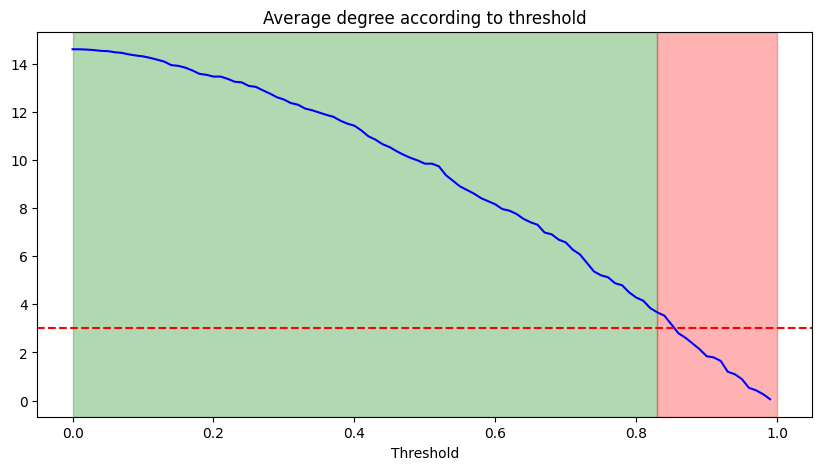

the best threshold is 0.8300000000000001 with an average degree of 4.054054054054054 and is connected: True


In [24]:
stations_np = stations_df[["Longitude", "Latitude"]].to_numpy()
dist_mat_condensed = pdist(stations_np, metric=get_geodesic_distance)
sigma = np.median(dist_mat_condensed)

thresholds = np.arange(0,1,0.01)
degrees = []
for idx, threshold in enumerate(thresholds):
    adjacency_matrix = squareform(get_exponential_similarity(dist_mat_condensed, sigma, threshold))
    if graphs.Graph(adjacency_matrix).is_connected():
        end = idx
    degrees.append(np.mean(adjacency_matrix.sum(axis=1)))
    
print("green when the graph is connected, red when not")
plt.figure(figsize=(10, 5))
plt.plot(thresholds, degrees, label="Average degree", color="blue")
plt.axvspan(0, thresholds[end], color='green', alpha=0.3)
plt.axvspan(thresholds[end], 1, color='red', alpha=0.3)
plt.axhline(3, color="red", linestyle="--")
plt.xlabel("Threshold")
plt.title("Average degree according to threshold")
plt.show()

best_threshold = thresholds[end]
adjacency_matrix = squareform(get_exponential_similarity(dist_mat_condensed, sigma, best_threshold))
G = graphs.Graph(adjacency_matrix)
print(f"the best threshold is {best_threshold} with an average degree of {np.mean(G.d)} and is connected: {G.is_connected()}")

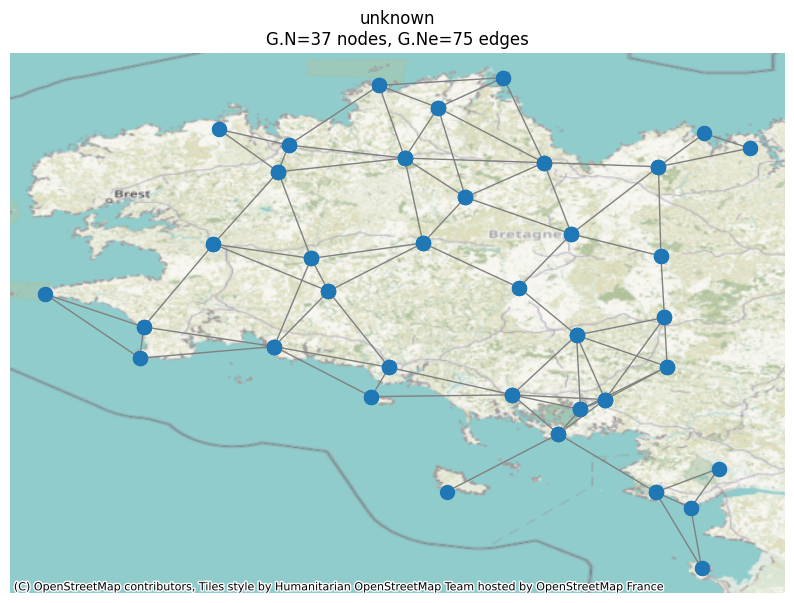

In [25]:
ax = stations_gdf.geometry.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G.set_coordinates(stations_np)
G.plot(ax=ax)

----
## <b>4.3/4.4: Compute smoothness

/var/folders/ds/pk0f0vys53j34_2xjrlcslx80000gn/T/ipykernel_11477/3927294804.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  smoothness.append(float(signal.T.dot(laplacian_matrix).dot(signal)))


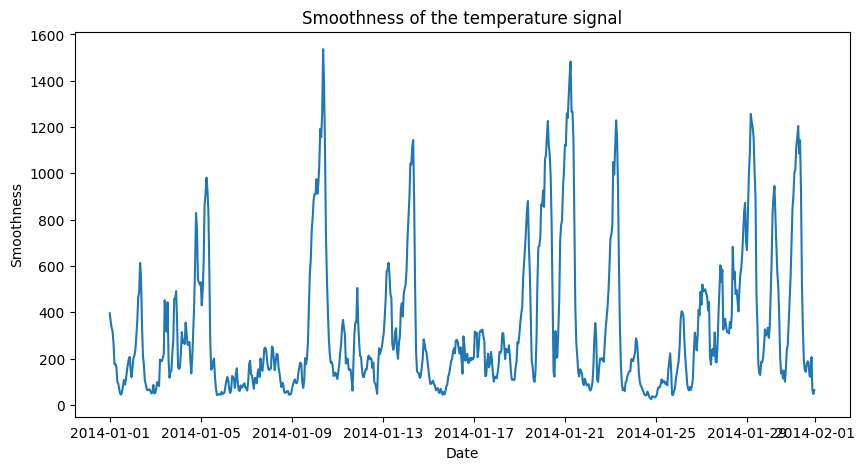

The signal is the smoothest at  2014-01-24 19:00:00
The signal is the least smooth at 2014-01-10 09:00:00


In [26]:
smoothness = []
laplacian_matrix = G.L.todense()

for date in temperature_df.index:
    signal = temperature_df.loc[date].to_numpy()
    smoothness.append(float(signal.T.dot(laplacian_matrix).dot(signal)))

plt.figure(figsize=(10, 5))
plt.plot(temperature_df.index, smoothness)
plt.xlabel("Date")
plt.ylabel("Smoothness")
plt.title("Smoothness of the temperature signal")
plt.show()

date_min_smoothness = temperature_df.index[np.argmin(smoothness)]
print(f"The signal is the smoothest at  {date_min_smoothness}")

date_max_smoothness = temperature_df.index[np.argmax(smoothness)]
print(f"The signal is the least smooth at {date_max_smoothness}")

----
----
# <b>Question 5</b>

In [27]:
adjacency_matrix = squareform(get_exponential_similarity(dist_mat_condensed, sigma, best_threshold))
G = graphs.Graph(adjacency_matrix)
laplacian_matrix = G.L.todense()
eigen_values, eigen_vectors = np.linalg.eig(laplacian_matrix)
eigen_values = np.real(eigen_values)

idx = np.argsort(eigen_values)
eigen_values = eigen_values[idx]
eigen_vectors = eigen_vectors[:, idx]
    
def classification_nodes(date):    
    M, R = 9, 3
    signal = temperature_df.loc[date].to_numpy()
    signal_hat = eigen_vectors.T @ signal

    labels = []
    for vertice in range(len(signal)):
        W_v = []
        for m in range(1, M+1):
            W = 0
            for i in range(len(eigen_values)):
                W += sagw_kernel(eigen_values[i], eigen_values[-1], m, M, R) * signal_hat[0,i] * eigen_vectors[vertice, i]
            W_v.append(W)
        energies = [sum(np.abs(W_v[:3])**2),sum(np.abs(W_v[3:6])**2),sum(np.abs(W_v[6:])**2)]
        labels.append(np.argmax(energies))
    return labels

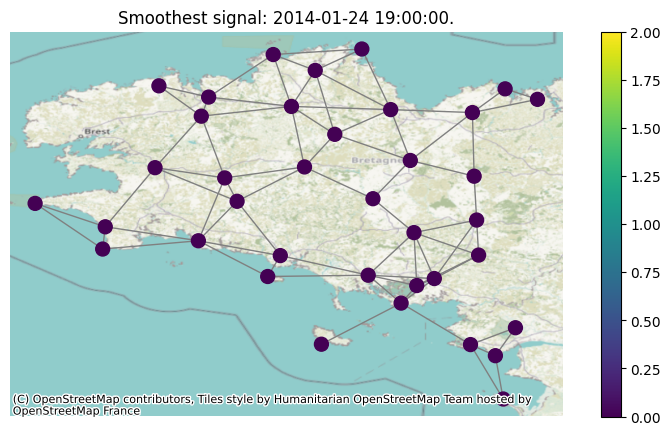

In [28]:
ax = stations_gdf.geometry.plot(figsize=(10, 5))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
G.set_coordinates(stations_np)
labels_min_smoothness = classification_nodes(date_min_smoothness)
G.plot_signal(np.array(labels_min_smoothness), ax=ax, limits=[0,2])
ax.set_axis_off()
_ = ax.set_title(f"Smoothest signal: {date_min_smoothness}.")

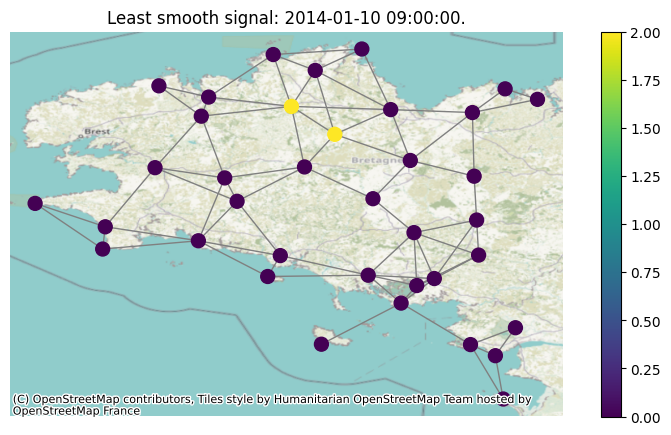

In [29]:
ax = stations_gdf.geometry.plot(figsize=(10, 5))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
G.set_coordinates(stations_np)
labels_max_smoothness = classification_nodes(date_max_smoothness)
G.plot_signal(np.array(labels_max_smoothness), ax=ax, limits=[0,2])
ax.set_axis_off()
_ = ax.set_title(f"Least smooth signal: {date_max_smoothness}.")

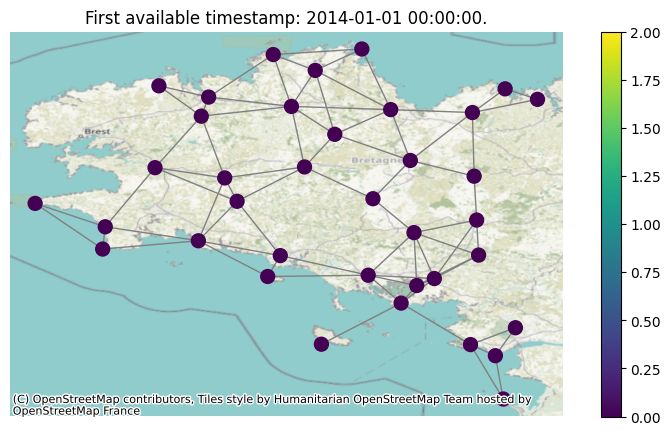

In [30]:
ax = stations_gdf.geometry.plot(figsize=(10, 5))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
G.set_coordinates(stations_np)
labels_0 = classification_nodes(temperature_df.index[0])
G.plot_signal(np.array(labels_0), ax=ax, limits=[0,2])
ax.set_axis_off()
_ = ax.set_title(f"First available timestamp: {temperature_df.index[0]}.")

----
----
# <b>Question 6</b>

In [31]:
def largest_community(labels):
    """find the largest community"""
    return np.argmax(np.bincount(labels))

In [32]:
# in temperature_df compute mean temperature for each date
mean_temperature_df = temperature_df.mean(axis=1).to_frame()
largest_comunities = []
for date in temperature_df.index:
    largest_comunities.append(largest_community(classification_nodes(temperature_df.index[0])))
    
# add a column to mean_temperature_df with the largest community
mean_temperature_df["largest_community"] = largest_comunities
mean_temperature_df.columns = ["mean_temperature", "largest_community"]

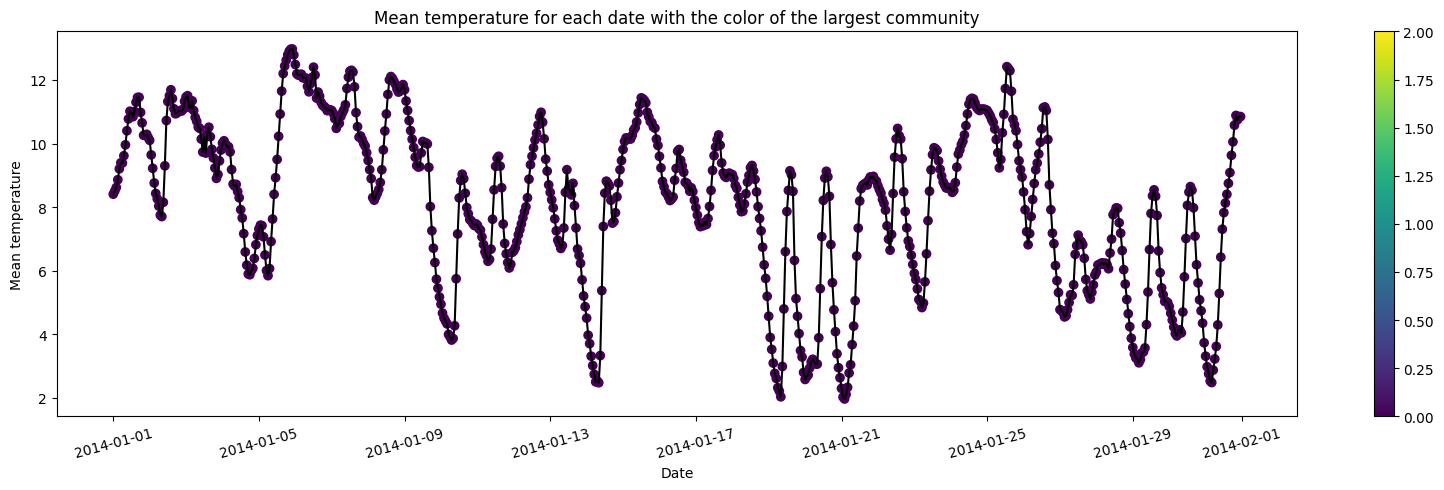

In [33]:
plt.figure(figsize=(20, 5))
plt.scatter(mean_temperature_df.index, mean_temperature_df["mean_temperature"], c=mean_temperature_df["largest_community"], vmin=0, vmax=2)
plt.plot(mean_temperature_df.index, mean_temperature_df["mean_temperature"], '-k')
cbar = plt.colorbar()
plt.xlabel("Date")
plt.xticks(rotation=15)
plt.ylabel("Mean temperature")
plt.title("Mean temperature for each date with the color of the largest community")
plt.show()

----
----
# <b>Question 7</b>